In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.stats import percentileofscore
import shap
import pickle

Read in label/unlabel df created in inspire_eda 

In [2]:
df = pd.read_csv('df_final.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Num_authors_mean,cpy_max,cpy_mean,Productivity,collab_cpy_mean_mean,collab_cpy_mean_max,collab_cpy_max_mean,collab_cpy_max_max,Label
0,1.096154,99.604167,7.035821,3.250000,4.113859,7.362778,51.224900,173.105263,Active
1,2.000000,0.428571,0.307143,1.333333,0.557216,0.557216,5.142857,5.142857,Churn
2,3.875000,6.800000,0.917031,1.263158,1.422363,5.295698,10.267004,155.208333,Active
3,4.666667,2.153846,1.041958,1.000000,1.240559,1.912698,5.930101,14.230769,Churn
4,2.666667,0.375000,0.125000,0.750000,1.113455,1.328073,12.986111,26.375000,Churn


Create predictors and target

In [3]:
features = list(df.columns)[:-1]
X = df[features]
y = np.where(df.Label == 'Active', 1, 0)

### As expected, features are highly correlated

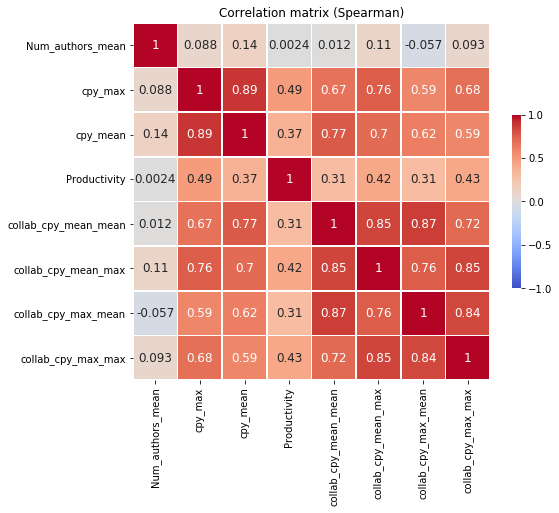

In [5]:
# Plot Spearman Correlation matrix

fig, ax = plt.subplots(figsize=(8, 8)) 

spearman_corr = pd.DataFrame(spearmanr(X).correlation, index=features, columns=features)

spearman_heatmap = sns.heatmap(spearman_corr,
                     square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
ax.set_yticklabels(spearman_corr.columns, rotation = 0)
ax.set_xticklabels(spearman_corr.columns)
ax.set_title('Correlation matrix (Spearman)')
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Clustering to visualize most correlated features

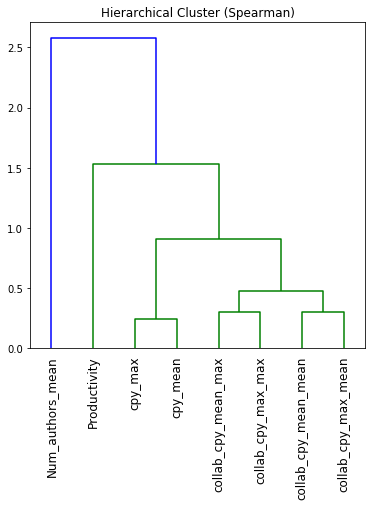

In [6]:
# Plot Hierarchical Clustering

fig, ax = plt.subplots(1, figsize=(6, 6))
corr_linkage = hierarchy.ward(spearmanr(X).correlation)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax.set_title('Hierarchical Cluster (Spearman)')
plt.show()

### Model Selection and Diagnosis

In [7]:
def score_CV(model, data, metric):
    score = cross_val_score(model, data, y, cv=5, scoring=metric)
    print(metric, 'mean:', '%.2f'%np.mean(score))

Simple linear model may not fully capture feature complexity

accuracy mean: 0.84
roc_auc mean: 0.92


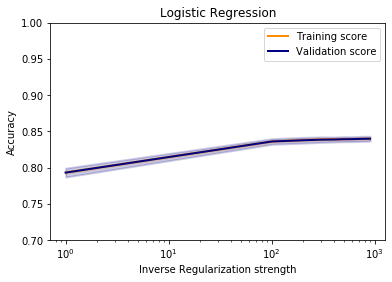

In [8]:
# For logistic regression should first scale features
X_scaled = pd.DataFrame()
for f in features:
    X_scaled[f] = (X[f] - X[f].min()) / (X[f].max() - X[f].min())

logreg = LogisticRegression(solver='newton-cg', C=1000)
score_CV(logreg, X_scaled, 'accuracy')
score_CV(logreg, X_scaled, 'roc_auc')

# Plot Validation Curve

param_range = np.arange(1,1000,100)
train_scores, valid_scores = validation_curve(logreg, X_scaled, y, 'C', param_range, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Logistic Regression")
plt.xlabel('Inverse Regularization strength')
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Use Random Forest as a benchmark

In [9]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy', random_state=0)
score_CV(rf, X, 'accuracy')
score_CV(rf, X, 'roc_auc')

accuracy mean: 0.88
roc_auc mean: 0.95


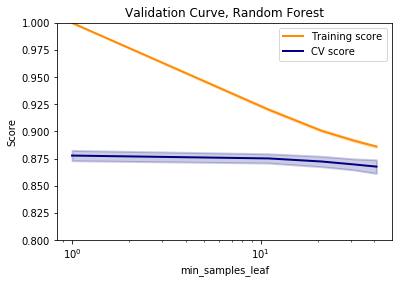

In [10]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy', random_state=0)

# Plot validation curve
param_range = np.arange(1,51,10)
train_scores, valid_scores = validation_curve(rf, X, y, 'min_samples_leaf', param_range, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve, Random Forest")
plt.xlabel('min_samples_leaf')
plt.ylabel("Score")
plt.ylim(0.8, 1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="CV score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

General feature importance from tree splitting criterion (entropy information gain)

Feature ranking:
feature cpy_max (0.26)
feature collab_cpy_max_max (0.16)
feature cpy_mean (0.12)
feature collab_cpy_mean_max (0.12)
feature Productivity (0.10)
feature collab_cpy_max_mean (0.10)
feature collab_cpy_mean_mean (0.09)
feature Num_authors_mean (0.05)


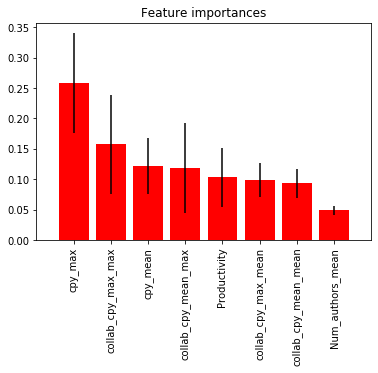

In [8]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy', min_samples_leaf=10, random_state=0)

rf.fit(X, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
test = [features[f] for f in indices]
for f in range(X.shape[1]):
    print("feature %s (%.2f)" %(test[f], importances[indices[f]]))

# Plot feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), test, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

### Train forest on subset of features. CV scores barely affected

In [9]:
# Drop Num_authors_mean and collab_cpy_mean_mean (importance)
featuresub = ['cpy_max',
              'collab_cpy_max_max',
              'cpy_mean',
              'collab_cpy_mean_max',
              'Productivity',
              'collab_cpy_max_mean']
Xsub = X[featuresub]
rf = RandomForestClassifier(n_estimators=50, criterion='entropy', min_samples_leaf=10, random_state=0)
score_CV(rf, Xsub, 'accuracy')
score_CV(rf, Xsub, 'roc_auc')

accuracy mean: 0.87
roc_auc mean: 0.95


In [38]:
# For benchmark fit rf on full training dataset

rf = RandomForestClassifier(n_estimators=50, criterion='entropy', min_samples_leaf=10, random_state=0)
benchmark = rf.fit(Xsub, y)
pickle.dump(benchmark, open('model.pkl','wb'))
model = pickle.load(open('model.pkl','rb'))

### Explain individual feature importances on unlabeled author sample predictions using SHAP

In [14]:
# keep author name in unlabelled samples
df_nolabel = pd.read_csv('df_nolabel.csv')
df_nolabel['Name'] = df_nolabel['Unnamed: 0']
df_nolabel.set_index(df_nolabel['Name'], inplace=True)
df_nolabel.drop(['Unnamed: 0','Name'], axis=1, inplace=True)

model_preds = model.predict_proba(df_nolabel[featuresub])[:,1]
predictions = pd.DataFrame(model_preds, index=df_nolabel.index).rename(columns={0:'prediction'})
df_pred=pd.concat([predictions, df_nolabel], axis=1)

df_pred.head()

,prediction,Total_papers,Cites_min,Cites_max,Cites_mean,Year_first,Year_last,Num_authors_min,Num_authors_max,Num_authors_mean,cpy_max,cpy_mean,Lifespan,Productivity,collab_cpy_mean_mean,collab_cpy_mean_max,collab_cpy_max_mean,collab_cpy_max_max
Name,,,,,,,,,,,,,,,,,,
"Aalsma, L.",0.237933,6,0,25,9.500000,2017,2019,1,4,2.666667,8.333333,3.222222,3,2.000000,3.539349,6.873180,28.375000,69.333333
"Aasen, D.",0.384778,6,8,31,15.500000,2012,2018,3,4,3.166667,6.000000,3.038889,7,0.857143,3.947852,8.114749,20.559241,68.333333
"Aashish, S.",0.009643,6,0,5,2.666667,2016,2019,2,4,2.500000,1.666667,0.944444,4,1.500000,0.709782,1.223972,8.535714,16.714286
"Abakumova, V.",0.052561,7,0,7,1.857143,2017,2019,3,3,3.000000,1.750000,0.535714,3,2.333333,0.745962,1.145683,4.642857,6.714286
"Abalos, F.",0.147958,3,0,13,4.666667,2015,2018,1,4,2.333333,2.166667,0.833333,4,0.750000,2.000278,2.170139,5.317308,6.384615


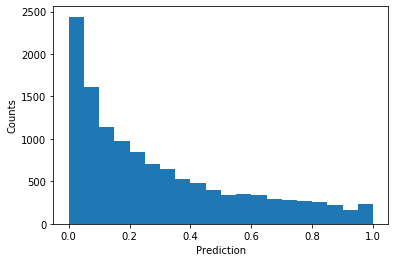

In [12]:
plt.hist(df_pred.prediction, bins=20)
plt.xlabel('Prediction') 
plt.ylabel('Counts')
plt.show()

In [72]:
def inspire_explainer(name):
    
    """
    Determine feature importances on active/churn prediction for individual unlabeled author.
    Inputs author name fitted to labeled data
    Outputs SHAP explainer plot 
    """
    
    meta = ['Year_first', 'Total_papers', 'Cites_mean', 'Cites_max']
    sample = df_pred.loc[name]
    year = sample.Year_first
    pred = sample.prediction
    field = df_pred.loc[df_pred.Year_first==year].prediction.values
    rank = percentileofscore(field, pred)
   
    print(sample[meta])
    print('Prediction:', '%.3f'%pred, 'Percentile:', '%.3f'%rank) 
    
    predictor = df_pred[featuresub].loc[name]
    explainer = shap.TreeExplainer(model, data=None, feature_perturbation="tree_path_dependent")
    shap_values = explainer.shap_values(predictor)
    shap.initjs()
    shapeplot = shap.force_plot(explainer.expected_value[1], shap_values[1], predictor)
    return shapeplot

### Model gives very low predictions for grad students, though this is to be expected

In [74]:
inspire_explainer('Narayan, V.')

Year_first      2018.00
Total_papers       4.00
Cites_mean        13.75
Cites_max         21.00
Name: Narayan, V., dtype: float64
Prediction: 0.072 Percentile: 64.752


### Model seemingly gives accurate and informative results for senior postdocs on the job market

In [75]:
inspire_explainer('Dror, J.')

Year_first      2013.000000
Total_papers      18.000000
Cites_mean        16.222222
Cites_max         53.000000
Name: Dror, J., dtype: float64
Prediction: 0.675 Percentile: 89.106


In [76]:
inspire_explainer('Harigaya, K.')

Year_first      2011.000000
Total_papers      87.000000
Cites_mean        20.908046
Cites_max        240.000000
Name: Harigaya, K., dtype: float64
Prediction: 0.999 Percentile: 99.894
